# Intro

 Es especialmente adecuado para:

- Datos horarios, diarios o semanales con suficientes datos históricos.
- Múltiples modelos estacionales relacionados con el comportamiento humano (día de la semana, estaciones).
- Días festivos importantes con espacios irregulares 
- Falta una cantidad razonable de datos.
- Cambios de tendencias históricas.
- Tendencias de crecimiento no lineal con saturación (límites de capacidad, etc.).

Prophet modela series temporales como un modelo aditivo generalizado (GAM) que combina la función de tendencia, la función de estacionalidad, los efectos de las vacaciones y un término de error en un solo modelo:

$$
y(t)= g(t)+ s(t)+h(t)+e_t
$$


- $𝑔(𝑡)$ : tendencia (cambios no periódicos)
- $𝑠(𝑡)$: estacionalidad (cambios periódicos)
- $ℎ(𝑡)$ : efecto vacaciones
- $e_𝑡$: término de error, valor predeterminado anterior 𝜖∼𝑁(0,0.5)

- **Puntos de cambio:** definen los cambios de tendencia. Pueden ser detectados por el propio algoritmo o también pueden ser definidos y ajustados.
  
- **Estacionalidad:** define funciones periódicas que pueden afectar los datos de series temporales. De manera predeterminada, PROPHET considera la estacionalidad anual, semanal y diaria, e intenta identificar tendencias que representen estos efectos periódicos en los datos.
  
- **Feriados:** los días especiales (como feriados u otros eventos recurrentes) también se pueden modelar con el modelo aditivo PROPHET. Las fechas se pueden agregar manualmente a través de un pandas.Dataframe, pero también hay conjuntos de feriados integrados para alrededor de una docena de países.
  
- **Orden de Fourier:** referente a la función de estacionalidad, este valor determina qué tan rápido puede cambiar y adaptarse, y también implica un modelo más ajustado (con el consiguiente riesgo de sobreajuste).
- **Parámetros de tendencia**

| Parámetro                 | Descripción                                                                                      |
|---------------------------|--------------------------------------------------------------------------------------------------|
| `growth`                  | "Linear" o "logistic" se usan para especificar si una tendencia es lineal o logística.           |
| `change points`           | Incluye fechas para posibles puntos de cambio (automático si no se especifica).                  |
| `n_changepoints`          | Si no se proporcionan puntos de cambio, puedes especificar el número de puntos de cambio a incluir automáticamente. |
| `changepoint_prior_scale` | Parámetro para ajustar la flexibilidad de la selección automática de puntos de cambio.           |

- **Estacionalidad y parámetros vacacionales**

| Parámetro               | Descripción                                                                         |
|-------------------------|-------------------------------------------------------------------------------------|
| `annual_seasonality`    | Para ajustar la estacionalidad anual.                                               |
| `weekly_seasonality`    | Para ajustar la estacionalidad semanal.                                             |
| `daily_seasonality`     | Ajusta la estacionalidad diaria.                                                    |
| `holidays`              | DataFrame de eventos que contiene el nombre y la fecha del día festivo.             |
| `season_prior_scale`    | Parámetro para ajustar la fuerza del modelo de estacionalidad.                      |
| `holiday_prior_scale`   | Parámetro para ajustar la fuerza del modelo de días festivos.                       |


- **Puntos de cambio de tendencia**
La tendencia de una serie temporal puede cambiar abruptamente. PROPHET intenta detectar estos cambios automáticamente mediante un laplaciano o un exponencial doble a priori. De manera predeterminada, los puntos de cambio solo se ajustan para el primer 80 % de la serie temporal, lo que permite un margen suficiente para la previsión real.

Para ajustar los cambios de tendencia, podemos usar el parámetro `changepoint_prior_scale`, que está configurado en 0,05 de forma predeterminada. Aumentar su valor haría que la tendencia fuera más flexible y reduciría el desajuste.

Establezcamos el valor en 0,5, como sugiere la guía de documentación de Prophet. Si queremos generar intervalos de incertidumbre para los componentes de tendencia y estacionalidad, debemos realizar un muestreo bayesiano completo, lo que se puede hacer utilizando el mcmc_samplesparámetro en Prophet.


Prophet es una biblioteca de pronóstico de series temporales de Python desarrollada por Facebook. Prophet detecta automáticamente la estacionalidad anual, semanal y diaria. Puede descomponer rápidamente los efectos de tendencia y estacionalidad.


- ¿Cómo entrenar un modelo de pronóstico de series de tiempo usando Prophet?
- ¿Cómo hacer predicciones y descomposición de series temporales?
- ¿Cómo identificar puntos de cambio en la tendencia?
- ¿Cómo hacer una validación cruzada de series temporales?
- ¿Cómo evaluar el rendimiento del modelo de series de tiempo usando Prophet?

### Paso 1: instalar e importar bibliotecas

In [1]:
#%pip install yfinance prophet


In [1]:
import numpy as np
import pandas as pd


import yfinance as yf

# Prophet
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

# VisualizaCION
import plotly.graph_objs as go

# Paso 2: obtenga datos de precios de Bitcoin

En el segundo paso, los datos del precio de Bitcoin se descargan de la API financiera de Yahoo. Estamos utilizando datos diarios de dos años de 2018 y 2019.

Yahoo Finance descarga datos con la fecha como índice. Usando reset_index, creamos un nuevo índice y usamos la fecha como columna. Esto se debe a que Prophet requiere que la variable de fecha y hora sea una columna para la entrada del modelo.

De forma predeterminada, la fecha es un tipo de cadena, pd.to_datetimela cambia a un formato DateTime.

In [2]:
# Descargar datos Bitcoin
data = yf.download(tickers='BTC-USD', start='2018-01-01', end='2024-08-30', interval = '1d')

# Restablecer el índice y tener la fecha como columna
data.reset_index(inplace=True)

# Cambiar la fecha al formato de fecha y hora
data['Date'] = pd.to_datetime(data['Date'])


data.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


In [3]:
# Declarar la figura
fig = go.Figure()

fig.add_trace(go.Candlestick(x=data.Date,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name = 'Bitcoin Data'))

**objetivo**  pronosticar el precio de cierre de Bitcoin. Prophet toma dos columnas como entradas, una columna de fecha y hora llamada "ds" y una columna de valor llamada "y". Por lo tanto, debemos eliminar todas las demás columnas, cambiar el nombre de "Fecha" a "ds" y "Cerrar" a "y".


In [4]:
# # Mantener solo la fecha y el precio de cierre
df = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Cambiar el nombre de la fecha a ds y cerrar el precio a y
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

df.head()

,ds,y
0,2018-01-01,13657.200195
1,2018-01-02,14982.099609
2,2018-01-03,15201.000000
3,2018-01-04,15599.200195
4,2018-01-05,17429.500000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2433 entries, 0 to 2432
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2433 non-null   datetime64[ns]
 1   y       2433 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 38.1 KB


# Paso 3: Train Test Split

crear un conjunto de datos de entrenamiento y de prueba. No podemos utilizar la división aleatoria para los datos de series temporales porque provoca una fuga de datos de fechas futuras a fechas pasadas. Por lo general, se selecciona una fecha límite. Los datos anteriores a la fecha límite son el conjunto de datos de entrenamiento y los datos posteriores a la fecha límite se utilizan como conjunto de datos de prueba.

En este ejemplo, se utiliza '2024–03–14' como fecha límite. Los primeros 23 meses se utilizan para la capacitación del modelo y el último mes se usa para pruebas.

In [7]:
# Train test split
df_train = df[df['ds']<='2024-06-29']
df_test = df[df['ds']>'2024-06-29']

# Print .
print('El conjunto de datos de entrenamiento tiene', len(df_train), 'que, van desde', df_train['ds'].min(), 'hasta', df_train['ds'].max())
print(' El conjunto de datos de prueba tiene', len(df_test), 'que, van desde', df_test['ds'].min(), 'hasta', df_test['ds'].max())

El conjunto de datos de entrenamiento tiene 2372 que, van desde 2018-01-01 00:00:00 hasta 2024-06-29 00:00:00
 El conjunto de datos de prueba tiene 61 que, van desde 2024-06-30 00:00:00 hasta 2024-08-29 00:00:00


In [8]:
df_test

,ds,y
2372,2024-06-30,62678.292969
2373,2024-07-01,62851.980469
2374,2024-07-02,62029.015625
2375,2024-07-03,60173.921875
2376,2024-07-04,56977.703125
...,...,...
2428,2024-08-25,64333.542969
2429,2024-08-26,62880.660156
2430,2024-08-27,59504.132812
2431,2024-08-28,59027.625000


## Paso 4: Entrene el modelo de series temporales con Prophet


Entrenar el modelo de series de tiempo utilizando el conjunto de datos de entrenamiento.

- `interval_width` especifica el intervalo de predicción. Cambiamos el valor predeterminado del intervalo de predicción del 80% al 95%. Hace que el límite superior y el límite inferior de la predicción sean más amplios.

- `n_changepoints` es el número de puntos de cambio en la tendencia de la serie temporal. El valor predeterminado es 25. Según la forma de los datos del precio de Bitcoin, se estableció en 7.

In [9]:
# Crea el modelo con una confianza interna del 95%
m = Prophet(interval_width=0.95, n_changepoints=7)

# Ajusta el modelo
m.fit(df_train)

22:52:15 - cmdstanpy - INFO - Chain [1] start processing
22:52:15 - cmdstanpy - INFO - Chain [1] done processing
22:52:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:52:16 - cmdstanpy - INFO - Chain [1] start processing
22:52:19 - cmdstanpy - INFO - Chain [1] done processing


La estacionalidad anual y la estacionalidad diaria se desactivan automáticamente. Esto se debe a que Prophet detecta que el conjunto de datos que estamos utilizando no tiene varios años completos de datos y no tiene unidades menores a un día

# Paso 5: utilice el modelo Prophet para hacer predicciones


El paso 5 utiliza el modelo Profeta entrenado para hacer la predicción. Usamos los últimos 31 días para crear el marco de datos futuro. Esto es lo mismo que usar el conjunto de datos de prueba que creamos anteriormente.

El resultado de la predicción contiene mucha información. Mantuvimos el valor predicho yhaty su valor límite superior e inferior del intervalo de predicción.

In [10]:
# Crear un marco de datos futuro para la predicción
future = m.make_future_dataframe(periods=60)

# Pronosticar los valores futuros del marco de datos
forecast = m.predict(future)

# Verifique los valores pronosticados y el pronóstico del límite
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2427,2024-08-24,67459.934577,56063.912068,78320.594777
2428,2024-08-25,67471.977945,55596.333435,78560.909350
2429,2024-08-26,67556.194956,56090.396274,78042.349298
2430,2024-08-27,67469.798647,56973.716504,78533.683347
2431,2024-08-28,67542.101927,56355.553273,78253.454186


El eje x es la fecha en la visualización del pronóstico y el eje y es el precio de cierre de Bitcoin. Los puntos negros son los precios reales en el conjunto de datos de entrenamiento y los puntos rojos son los precios reales previstos. La línea azul es la predicción del modelo de series temporales. El área sombreada es el intervalo de predicción del 95%

c:\Users\wsand\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\wsand\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



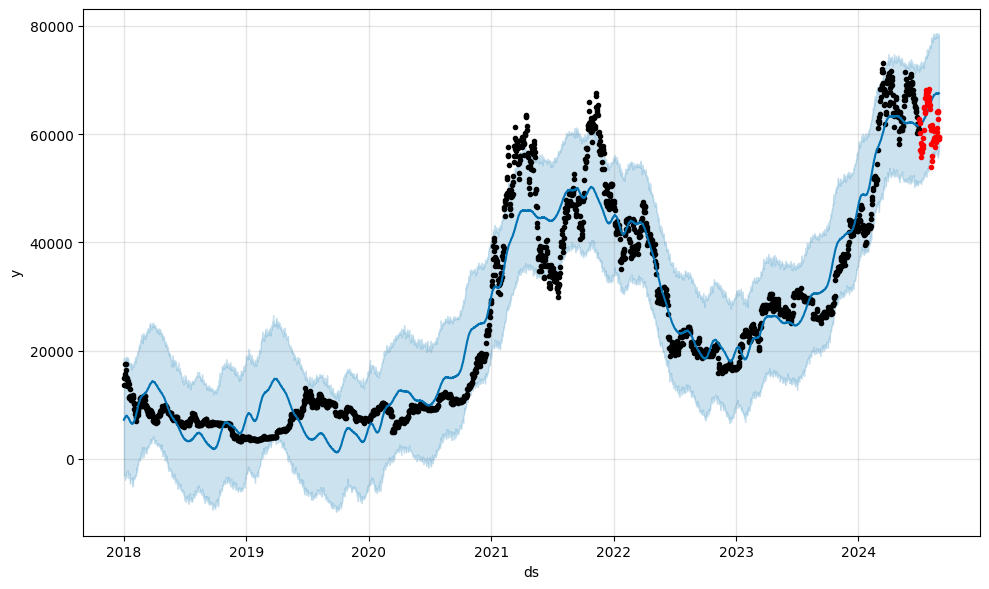

In [11]:
# Visualizar el pronostico
fig = m.plot(forecast)
ax = fig.gca()
ax.plot( df_test["ds"], df_test["y"], 'r.')

# Paso 6: Descomposición de series temporales



En el paso 6, descompondremos el pronóstico de la serie temporal.

-
-

c:\Users\wsand\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\wsand\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\wsand\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on t

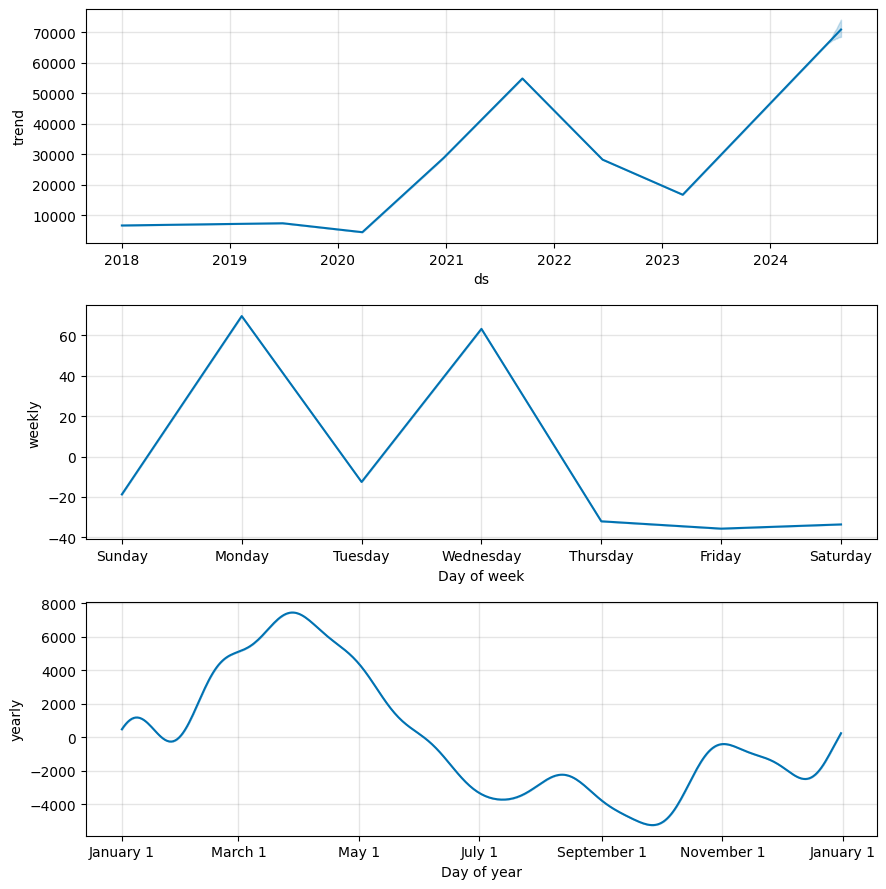

In [12]:
# Visualizar las componentes
m.plot_components(forecast);

# Paso 7: identificar los puntos de cambio


En el paso 7, discutiremos cómo identificar los puntos de cambio en la tendencia de la serie temporal.

Prophet identifica automáticamente los puntos de cambio en los datos de series temporales siguiendo los pasos a continuación:

- Utilice los datos del primer 80% de la serie temporal para identificar puntos de cambio. El valor predeterminado es 80% pero es un hiperparámetro que podemos cambiar.
- Identificar un gran número de fechas distribuidas uniformemente con posibles cambios de trayectoria.
- Aplique un previo escaso a las magnitudes de la tasa de cambio, que es similar a la regularización L1.
Podemos listar las fechas correspondientes a los puntos de cambio usando `.changepoints`.


In [13]:
# Puntos de cambio predeterminados
print(f'There are {len(m.changepoints)} change points. \nThe change points dates are \n{df.loc[df["ds"].isin(m.changepoints)]}')

There are 7 change points. 
The change points dates are 
             ds             y
271  2018-09-29   6601.959961
542  2019-06-27  11182.806641
813  2020-03-24   6734.803711
1083 2020-12-19  23869.832031
1354 2021-09-16  47783.359375
1625 2022-06-14  22206.792969
1896 2023-03-12  22163.949219


En la visualización, las líneas de puntos rojas representan los puntos de cambio. No incluye los siete puntos de cambio del gráfico. Sólo se incluyen los que tienen más cambios.

c:\Users\wsand\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\wsand\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



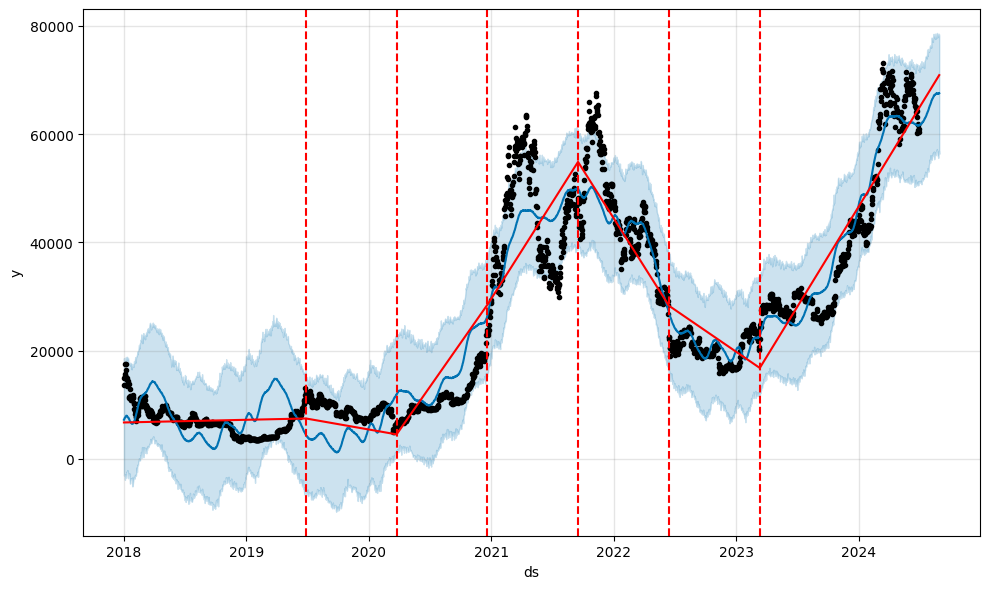

In [14]:

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# Paso 8: validación cruzada


En el paso 8, realizaremos una validación cruzada del modelo de series de tiempo. Prophet tiene una cross_validation función para automatizar la comparación entre los valores reales y previstos.

- m es el modelo entrenado.
- initial='500 days' significa que el modelo inicial se entrenará en los primeros 500 días de datos.
- period='60 days' significa que se agregarán 60 días al conjunto de datos de entrenamiento para cada modelo adicional.
- horizon = '30 days'significa que el modelo pronostica los próximos 30 días. Cuando horizonse proporciona solo, el valor predeterminado de Prophet initiales el triple de horizon, y period la mitad de horizon.
- parallel="processes"permite el procesamiento paralelo para la validación cruzada. Cuando la validación cruzada paralela se pueda realizar en una sola máquina, processesproporcione el mayor rendimiento. Para problemas más grandes, daskse puede utilizar para realizar una validación cruzada en varias máquinas.




In [15]:
# Cross validation
df_cv = cross_validation(m, initial='500 days', period='60 days', horizon = '30 days', parallel="processes")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-06-27,9293.863822,7805.530909,10572.663813,11182.806641,2019-06-26
1,2019-06-28,9390.087383,8064.840019,10690.773299,12407.332031,2019-06-26
2,2019-06-29,9501.609422,8130.175844,10877.919381,11959.371094,2019-06-26
3,2019-06-30,9527.972652,8131.720340,10825.151941,10817.155273,2019-06-26
4,2019-07-01,9548.691050,8145.434438,10966.674086,10583.134766,2019-06-26


# Paso 9: Evaluación del desempeño del modelo Prophet


El paso 9 evalúa el desempeño del modelo de validación cruzada.

- MSE (Error cuadrático medio) resume la diferencia al cuadrado entre lo real y la predicción y se divide por el número de predicciones.
- RMSE (error cuadrático medio) toma la raíz cuadrada de MSE.
- MAE (error absoluto medio) resume la diferencia absoluta entre lo real y la predicción y se divide por el número de predicciones.
- MAPE (Error porcentual absoluto medio) resume la diferencia porcentual absoluta entre lo real y la predicción y se divide por el número de predicciones. MAPE es independiente de la magnitud de los datos, por lo que puede usarse para comparar diferentes pronósticos. Pero no está definido cuando el valor real es cero.
- MDAPE (Error porcentual absoluto medio) es similar a MAPE. La diferencia es que calcula la mediana en lugar de tomar el promedio de la diferencia porcentual absoluta.
- SMAPE (Error porcentual absoluto medio simétrico) es similar a MAPE. La diferencia es que al calcular el error porcentual absoluto, el denominador es el valor real de MAPE y el promedio del valor real y previsto de SMAPE.

In [16]:
df_p = performance_metrics(df_cv)
df_p.head()


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,5.102101e+07,7142.899154,5325.514174,0.173813,0.137880,0.185296,0.763441
1,4 days,5.859408e+07,7654.677066,5688.432356,0.184976,0.141194,0.195854,0.720430
2,5 days,6.498601e+07,8061.390013,5959.425239,0.194221,0.149866,0.204228,0.677419
3,6 days,7.426377e+07,8617.642812,6267.499353,0.203251,0.156640,0.211967,0.645161
4,7 days,8.081497e+07,8989.714898,6545.474140,0.213298,0.176641,0.221011,0.591398


`plot_cross_validation_metric` El método de Prophet nos ayuda a trazar los resultados del rendimiento de la validación cruzada.

- El eje $x$ es el horizonte. Como establecimos el horizonte en 30 días, el eje x tiene un valor de hasta 30.
- El eje y es la métrica que nos interesa. La utilizamos mapecomo ejemplo en esta visualización.
- Cada día podemos ver tres puntos. Esto se debe a que hay tres modelos en la validación cruzada y cada punto representa el MAPE de un modelo.
- La línea es el rendimiento agregado de todos los modelos. Podemos ver que el valor MAPE aumenta con los días, lo cual es de esperarse porque las series de tiempo tienden a hacer mejores predicciones para el futuro cercano que para el futuro lejano.

c:\Users\wsand\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

c:\Users\wsand\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



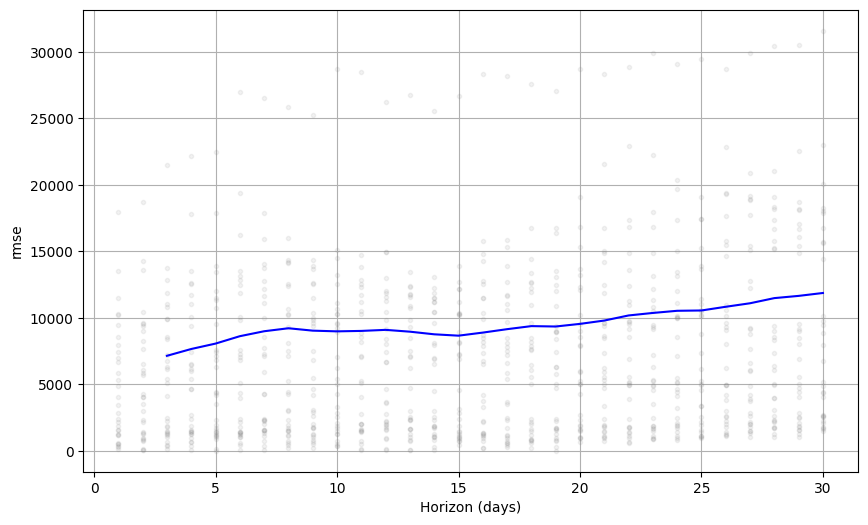

In [20]:
# Visualizar las metricas
fig = plot_cross_validation_metric(df_cv, metric='rmse')

# Reference

* [Prophet documentation](https://facebook.github.io/prophet/docs/quick_start.html)
* [Prophet cross-validation and hyperparameter tuning](https://facebook.github.io/prophet/docs/diagnostics.html)
* [Prophet change point detection](https://facebook.github.io/prophet/docs/trend_changepoints.html)
